In [3]:
import numpy as np
import pandas as pd

import requests
import sys
sys.path.append('..')
from ltr.client.solr_client import SolrClient

client = SolrClient(host='http://aips-solr:8983/solr')



## Load every session we have data for

load every session we have data for as the raw session clickstream data (what was returned, clicked, and not clicked)

In [19]:
def all_sessions():
    import glob
    sessions = pd.concat([pd.read_csv(f, compression='gzip')
                          for f in glob.glob('data/*_sessions.gz')])
    return sessions.rename(columns={'clicked_doc_id': 'doc_id'})
    
sessions = all_sessions()
sessions

,sess_id,query,rank,doc_id,clicked
0,50002,blue ray,0.0,600603141003,True
1,50002,blue ray,1.0,827396513927,False
2,50002,blue ray,2.0,24543672067,False
3,50002,blue ray,3.0,719192580374,False
4,50002,blue ray,4.0,885170033412,True
...,...,...,...,...,...
74995,5001,transformers dark of the moon,10.0,47875841369,False
74996,5001,transformers dark of the moon,11.0,97363560449,False
74997,5001,transformers dark of the moon,12.0,93624956037,False
74998,5001,transformers dark of the moon,13.0,97363532149,False


## Judgments using Beta Dist

We have about a dozen queries where we've simulated the click stream. Here we compute the SDBN judgments, using a beta distribution, on each of these queries. The code in `sessions_to_sdbn` just repeats what we did in this section of the book, just for every query we have data for. 

We then convert these to the `Judgments` object we use in Chapter 10

In [149]:
from ltr.judgments import Judgment

# Create a judgment list with our queries
def sessions_to_sdbn(query):
    """ Compute SDBN of the provided query as a dataframe.
        Where we left off at end of 'overcoming confidence bias' 
        """
    sdbn_sessions = sessions[sessions['query'] == query].copy().set_index('sess_id')

    last_click_per_session = sdbn_sessions.groupby(['clicked', 'sess_id'])['rank'].max()[True]

    sdbn_sessions['last_click_rank'] = last_click_per_session
    sdbn_sessions['examined'] = sdbn_sessions['rank'] <= sdbn_sessions['last_click_rank']

    sdbn = sdbn_sessions[sdbn_sessions['examined']].groupby('doc_id')[['clicked', 'examined']].sum()
    sdbn['grade'] = sdbn['clicked'] / sdbn['examined']

    sdbn = sdbn.sort_values('grade', ascending=False)

    PRIOR_GRADE=0.2
    PRIOR_WEIGHT=10
    sdbn['prior_a'] = PRIOR_GRADE*PRIOR_WEIGHT
    sdbn['prior_b'] = (1-PRIOR_GRADE)*PRIOR_WEIGHT

    sdbn['posterior_a'] = sdbn['prior_a'] +  sdbn['clicked']
    sdbn['posterior_b'] = sdbn['prior_b'] + (sdbn['examined'] - sdbn['clicked'])

    sdbn['beta_grade'] = sdbn['posterior_a'] / (sdbn['posterior_a'] + sdbn['posterior_b'])

    sdbn.sort_values('beta_grade', ascending=False)
    return sdbn


def sdbn_to_judgments(sdbn, query, qid):
    judgments = []
    for row_dict in sdbn.reset_index().to_dict(orient="records"):
        # Round grade to 10ths, Map 0.3 -> 3, etc
        grade = round(row_dict['beta_grade'], 1) * 10
        judgments.append(Judgment(doc_id=row_dict['doc_id'],
                                  keywords=query,
                                  qid=qid,
                                  grade=int(grade))
                        )
    return judgments


simulated_queries = ['dryer', 'bluray', 'blue ray', 'headphones', 'ipad', 'iphone',
                     'kindle', 'lcd tv', 'macbook', 'nook', 'star trek', 'star wars',
                     'transformers dark of the moon']



judgments = []
for qid, query in enumerate(simulated_queries):
    sdbn = sessions_to_sdbn(query)
    judgments.extend(sdbn_to_judgments(sdbn, query, qid))
    
    
judgments

[Judgment(grade=4,qid=0,keywords=dryer,doc_id=856751002097,features=[],weight=1,
 Judgment(grade=4,qid=0,keywords=dryer,doc_id=48231011396,features=[],weight=1,
 Judgment(grade=3,qid=0,keywords=dryer,doc_id=84691226727,features=[],weight=1,
 Judgment(grade=3,qid=0,keywords=dryer,doc_id=74108007469,features=[],weight=1,
 Judgment(grade=3,qid=0,keywords=dryer,doc_id=12505525766,features=[],weight=1,
 Judgment(grade=3,qid=0,keywords=dryer,doc_id=36725578241,features=[],weight=1,
 Judgment(grade=3,qid=0,keywords=dryer,doc_id=48231011402,features=[],weight=1,
 Judgment(grade=3,qid=0,keywords=dryer,doc_id=12505527456,features=[],weight=1,
 Judgment(grade=2,qid=0,keywords=dryer,doc_id=74108096487,features=[],weight=1,
 Judgment(grade=2,qid=0,keywords=dryer,doc_id=36725561977,features=[],weight=1,
 Judgment(grade=2,qid=0,keywords=dryer,doc_id=84691226703,features=[],weight=1,
 Judgment(grade=2,qid=0,keywords=dryer,doc_id=665331101927,features=[],weight=1,
 Judgment(grade=2,qid=0,keywords=dryer

In [154]:
sessions_to_sdbn('dryer')

,clicked,examined,grade,prior_a,prior_b,posterior_a,posterior_b,beta_grade
doc_id,,,,,,,,
856751002097,133.0,323.0,0.411765,2.0,8.0,135.0,198.0,0.405405
48231011396,166.0,423.0,0.392435,2.0,8.0,168.0,265.0,0.387991
84691226727,804.0,2541.0,0.316411,2.0,8.0,806.0,1745.0,0.315955
74108007469,208.0,708.0,0.293785,2.0,8.0,210.0,508.0,0.292479
12505525766,268.0,974.0,0.275154,2.0,8.0,270.0,714.0,0.274390
36725578241,130.0,477.0,0.272537,2.0,8.0,132.0,355.0,0.271047
48231011402,213.0,818.0,0.260391,2.0,8.0,215.0,613.0,0.259662
12505527456,110.0,428.0,0.257009,2.0,8.0,112.0,326.0,0.255708
74108096487,235.0,1097.0,0.214221,2.0,8.0,237.0,870.0,0.214092


## Create a simple feature set

Here's a simple feature set. The ranking function can _only be as good as the training data and features_. Experiment with different features to see what builds the most robust model.

In [151]:

requests.delete('http://aips-solr:8983/solr/products/schema/feature-store/test')

import requests

feature_set = [
    {
      "name" : "name_bm25",
      "store": "test",
      "class" : "org.apache.solr.ltr.feature.SolrFeature",
      "params" : { #q=title:({$keywords})
        "q" : "name:(${keywords})"
      }
    },
    {
      "name" : "longDesciption_bm25",
      "store": "test",
      "class" : "org.apache.solr.ltr.feature.SolrFeature",
      "params" : {
        "q" : "longDescription:(${keywords})"
      }
    },
    {
      "name" : "name_constant",
      "store": "test",
      "class" : "org.apache.solr.ltr.feature.SolrFeature",
      "params" : { #q=title:({$keywords})
        "q" : "name:(${keywords})^=1"
      }
    },
    {
      "name" : "shortDesciption_bm25",
      "store": "test",
      "class" : "org.apache.solr.ltr.feature.SolrFeature",
      "params" : {
        "q" : "shortDescription:(${keywords})"
      }
    },
    {
      "name" : "shortDescription_constant",
      "store": "test",
      "class" : "org.apache.solr.ltr.feature.SolrFeature",
      "params" : { #q=title:({$keywords})
        "q" : "shortDescription:(${keywords})^=1"
      }
    },
    {
      "name" : "longDescription_constant",
      "store": "test",
      "class" : "org.apache.solr.ltr.feature.SolrFeature",
      "params" : { #q=title:({$keywords})
        "q" : "longDescription:(${keywords})^=1"
      }
    },
    {
      "name" : "longDesciptionPhrase_bm25",
      "store": "test",
      "class" : "org.apache.solr.ltr.feature.SolrFeature",
      "params" : {
        "q" : "longDescription:\"${keywords}\""
      }
    },
    {
      "name" : "shortDesciptionPhrase_bm25",
      "store": "test",
      "class" : "org.apache.solr.ltr.feature.SolrFeature",
      "params" : {
        "q" : "shortDescription:\"${keywords}\""
      }
    },
    {
      "name":  "nameLength",
      "store": "test",
      "class": "org.apache.solr.ltr.feature.FieldLengthFeature",
      "params": {
          "field": "name"
      }
    },
    {
      "name":  "shortDescriptionLength",
      "store": "test",
      "class": "org.apache.solr.ltr.feature.FieldLengthFeature",
      "params": {
          "field": "shortDescription"
      }
    },
    {
      "name":  "longDescriptionLength",
      "store": "test",
      "class": "org.apache.solr.ltr.feature.FieldLengthFeature",
      "params": {
          "field": "longDescription"
      }
    },
    {
      "name":  "manufacturerLength",
      "store": "test",
      "class": "org.apache.solr.ltr.feature.FieldLengthFeature",
      "params": {
          "field": "longDescription"
      }
    }
]

resp = requests.put('http://aips-solr:8983/solr/products/schema/feature-store',
                    json=feature_set)
resp, resp.text

(<Response [200]>,
 '{\n  "responseHeader":{\n    "status":0,\n    "QTime":5}}\n')

In [152]:
!cat data/product_judgments.txt

# qid:0: dryer*1
# qid:1: bluray*1
# qid:2: blue ray*1
# qid:3: headphones*1
# qid:4: ipad*1
# qid:5: iphone*1
# qid:6: kindle*1
# qid:7: lcd tv*1
# qid:8: macbook*1
# qid:9: nook*1
# qid:10: star trek*1
# qid:11: star wars*1
# qid:12: transformers dark of the moon*1

3	qid:0	 # 856751002097	dryer
3	qid:0	 # 48231011396	dryer
3	qid:0	 # 84691226727	dryer
3	qid:0	 # 74108007469	dryer
2	qid:0	 # 12505525766	dryer
2	qid:0	 # 36725578241	dryer
2	qid:0	 # 48231011402	dryer
2	qid:0	 # 12505527456	dryer
2	qid:0	 # 74108096487	dryer
2	qid:0	 # 36725561977	dryer
2	qid:0	 # 84691226703	dryer
2	qid:0	 # 665331101927	dryer
2	qid:0	 # 783722274422	dryer
2	qid:0	 # 14381196320	dryer
2	qid:0	 # 77283045400	dryer
1	qid:0	 # 74108056764	dryer
1	qid:0	 # 883049066905	dryer
1	qid:0	 # 12505451713	dryer
1	qid:0	 # 36172950027	dryer
1	qid:0	 # 883929085118	dryer
4	qid:1	 # 600603141003	bluray
5	qid:1	 # 27242813908	bluray
3	qid:1	 # 600603132872	bluray
2	qid:1	 # 36725608894	bluray
2	qid:1	 # 25192107191	b

## Log features from Solr

Log all the features to hydrate the judgmenst list

In [153]:
from ltr.log import FeatureLogger
from ltr.judgments import judgments_open
from itertools import groupby
from ltr import download

ftr_logger=FeatureLogger(client, index='products', feature_set='test', id_field='upc')

with judgments_open('data/product_judgments.txt') as judgment_list:
    for qid, query_judgments in groupby(judgments, key=lambda j: j.qid):
        ftr_logger.log_for_qid(judgments=query_judgments, 
                               qid=qid,
                               keywords=judgment_list.keywords(qid))

logged_judgments = ftr_logger.logged

# Now should have lots of judgments with title_bm25, overview_bm25, and release_year 
# logged out
logged_judgments

Recognizing 13 queries...
{!terms f=upc}856751002097,48231011396,84691226727,74108007469,12505525766,36725578241,48231011402,12505527456,74108096487,36725561977,84691226703,665331101927,783722274422,14381196320,77283045400,74108056764,883049066905,12505451713,36172950027,883929085118
Searching products [Status: 200]
Discarded 0 Keep 20
{!terms f=upc}600603141003,27242813908,600603132872,36725608894,25192107191,36725608511,605342041546,883929140855,786936817232,22265004517,719192580374,24543742180,36725608443,23942973416,36725617605,27242815414,826663129342,58231306590,27242809758,36725608436,36725617506,711719983156,186156000290,58231300826,23942972389,786936805017,25192073007,885170038875,711719804604,27242809710
Searching products [Status: 200]
Missing doc 600603141003
Missing doc 600603132872
Discarded 2 Keep 28
{!terms f=upc}27242815414,600603132872,827396513927,600603141003,885170033412,883929140855,24543672067,813774010904,36725617605,786936817232,36725608443,719192580374,2519207

[Judgment(grade=4,qid=0,keywords=dryer,doc_id=856751002097,features=[2.9048662, 2.4980226, 1.0, 0.0, 0.0, 1.0, 2.4980226, 0.0, 5.0, 17.0, 25.0, 25.0],weight=1,
 Judgment(grade=4,qid=0,keywords=dryer,doc_id=48231011396,features=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 20.0, 20.0, 20.0],weight=1,
 Judgment(grade=3,qid=0,keywords=dryer,doc_id=84691226727,features=[2.3211834, 2.0896797, 1.0, 0.0, 0.0, 1.0, 2.0896797, 0.0, 9.0, 13.0, 37.0, 37.0],weight=1,
 Judgment(grade=3,qid=0,keywords=dryer,doc_id=74108007469,features=[2.443951, 2.0076346, 1.0, 0.0, 0.0, 1.0, 2.0076346, 0.0, 8.0, 13.0, 40.0, 40.0],weight=1,
 Judgment(grade=3,qid=0,keywords=dryer,doc_id=12505525766,features=[2.3211834, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 8.0, 25.0, 25.0],weight=1,
 Judgment(grade=3,qid=0,keywords=dryer,doc_id=36725578241,features=[2.3211834, 2.3452606, 1.0, 0.0, 0.0, 1.0, 2.3452606, 0.0, 9.0, 16.0, 29.0, 29.0],weight=1,
 Judgment(grade=3,qid=0,keywords=dryer,doc_id=48231011402,features=[2.321183

## Normalize features

Normalize features using mean & std deviation.

In [135]:
from ltr.judgments import Judgment

def normalize_features(logged_judgments):
    all_features = []
    means = [0] * len(logged_judgments[0].features)
    for judgment in logged_judgments:
        for idx, f in enumerate(judgment.features):
            means[idx] += f
        all_features.append(judgment.features)
    
    for i in range(len(means)):
        means[i] /= len(logged_judgments)
      
    std_devs = [0.0] * len(logged_judgments[0].features)
    for judgment in logged_judgments:
        for idx, f in enumerate(judgment.features):
            std_devs[idx] += (f - means[idx])**2
            
    from math import sqrt
    for i in range(len(std_devs)):
        std_devs[i] /= len(logged_judgments)
        std_devs[i] = sqrt(std_devs[i])
        
    # Normalize!
    normed_judgments = []
    for judgment in logged_judgments:
        normed_features = [0.0] * len(judgment.features)
        for idx, f in enumerate(judgment.features):
            normed = (f - means[idx]) / std_devs[idx]
            normed_features[idx] = normed
        normed_judgment=Judgment(qid=judgment.qid,
                                 keywords=judgment.keywords,
                                 doc_id=judgment.doc_id,
                                 grade=judgment.grade,
                                 features=normed_features)
        normed_judgment.old_features=judgment.features
        normed_judgments.append(normed_judgment)

    return means, std_devs, normed_judgments

means, std_devs, normed_judgments = normalize_features(ftr_logger.logged)

normed_judgments

[Judgment(grade=4,qid=0,keywords=dryer,doc_id=856751002097,features=[0.3665361033134543, 1.0194711043024538, 0.6560333427772118, -0.45524489503146476, -0.4824181513244228, 1.0830867569483622, 1.2184616036013884, -0.3292943694788357, -1.368476192583542, 0.35640924511252914, -0.3690184363556925, -0.3690184363556925],weight=1,
 Judgment(grade=4,qid=0,keywords=dryer,doc_id=48231011396,features=[-0.9898227489722801, -0.800413739284521, -1.5243127670411685, -0.45524489503146476, -0.4824181513244228, -0.9232870714969645, -0.6616168780504772, -0.3292943694788357, 0.18411225884156082, 0.6484867650798475, -0.4608127201277645, -0.4608127201277645],weight=1,
 Judgment(grade=3,qid=0,keywords=dryer,doc_id=84691226727,features=[0.09399916763396453, 0.7219809796349059, 0.6560333427772118, -0.45524489503146476, -0.4824181513244228, 1.0830867569483622, 0.911131838280082, -0.3292943694788357, -0.12640543144345975, -0.033027448177228684, -0.14871215530271958, -0.14871215530271958],weight=1,
 Judgment(grad

In [136]:
means

[2.1198686782890857,
 1.0986693015929196,
 0.6991150442477876,
 0.382151427138643,
 0.1887905604719764,
 0.46017699115044247,
 0.8790770864306785,
 0.3768952147492624,
 9.4070796460177,
 13.339233038348082,
 45.100294985250734,
 45.100294985250734]

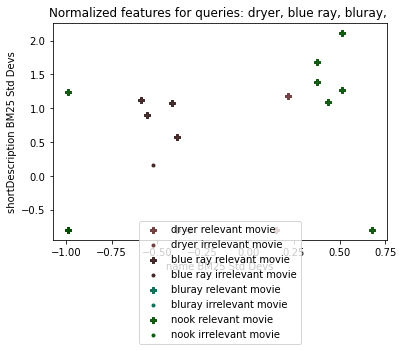

In [137]:
from ltr.plots import plot_judgments

plot_judgments(qids=[0,2,1,9], 
               xlabel="name BM25 Std Devs",
               ylabel="shortDescription BM25 Std Devs",
               title_prepend="Normalized features for queries:",
               judg_list=normed_judgments)

## Pairwise Transform

Track the difference between relevant / irrelevant docs.

In [138]:
import numpy as np
from ltr.judgments import judgments_from_file, judgments_to_nparray

def pairwise_transform(normed_judgments, weigh_difference = True):
        
    from itertools import groupby
    predictor_deltas = []
    feature_deltas = []
    
    # For each query's judgments
    for qid, query_judgments in groupby(normed_judgments, key=lambda j: j.qid):

        # Annoying issue consuming python iterators, we ensure we have two
        # full copies of each query's judgments
        query_judgments_copy_1 = list(query_judgments) 
        query_judgments_copy_2 = list(query_judgments_copy_1)

        # Examine every judgment combo for this query, 
        # if they're different, store the pairwise difference:
        # +1 if judgment1 more relevant
        # -1 if judgment2 more relevant
        for judgment1 in query_judgments_copy_1:
            for judgment2 in query_judgments_copy_2:
                
                j1_features=np.array(judgment1.features)
                j2_features=np.array(judgment2.features)
                
                if judgment1.grade > judgment2.grade:
                    diff = judgment1.grade - judgment2.grade if weigh_difference else 1.0
                    predictor_deltas.append(+1)
                    feature_deltas.append(diff * (j1_features-j2_features))
                elif judgment1.grade < judgment2.grade:
                    diff = judgment2.grade - judgment1.grade if weigh_difference else 1.0
                    predictor_deltas.append(-1)
                    feature_deltas.append(diff * (j1_features-j2_features))

    # For training purposes, we return these as numpy arrays
    return np.array(feature_deltas), np.array(predictor_deltas)

feature_deltas, predictor_deltas = pairwise_transform(normed_judgments)

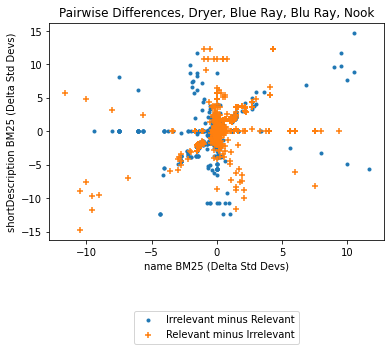

In [139]:
from ltr.plots import plot_pairwise_data

# Filter down to a judgment list of our two fav queries 
# out of the normalized data
just_these_queries = []
for j in normed_judgments:
    if j.qid == 0 or j.qid == 2 or j.qid == 1 or j.qid == 9:
        just_these_queries.append(j)

# Pairwise transform just these two, and plot
features, predictors = pairwise_transform(just_these_queries)
plot_pairwise_data(features, predictors,
                   xlabel="name BM25 (Delta Std Devs)",
                   ylabel="shortDescription BM25 (Delta Std Devs)",
                   title="Pairwise Differences, Dryer, Blue Ray, Blu Ray, Nook")

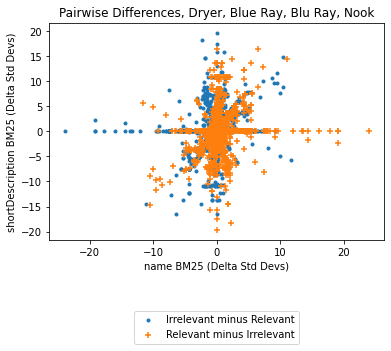

In [140]:
plot_pairwise_data(feature_deltas, predictor_deltas,
                   xlabel="name BM25 (Delta Std Devs)",
                   ylabel="shortDescription BM25 (Delta Std Devs)",
                   title="Pairwise Differences, Dryer, Blue Ray, Blu Ray, Nook")

In [141]:
from sklearn import svm
model = svm.LinearSVC(max_iter=10000, verbose=1)
model.fit(feature_deltas, predictor_deltas)
model.coef_

[LibLinear]

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



array([[ 0.0155125 ,  0.03067734,  0.14210029, -0.09805822,  0.11853772,
         0.03004014, -0.12730618, -0.03950859, -0.02448733, -0.02621274,
         0.01232265,  0.01232265]])

In [142]:
import json

linear_model = {
  "store": "test",
  "class": "org.apache.solr.ltr.model.LinearModel",
  "name": "test_model",
  "features": [
  ],
  "params": {
      "weights": {
      }
  }
}

import math
ftr_model = {}
ftr_names = [ftr['name'] for ftr in feature_set]
for idx, ftr_name in enumerate(ftr_names):
    config = {
        "name": ftr_name,
        "norm": {
            "class": "org.apache.solr.ltr.norm.StandardNormalizer",
            "params": {
                "avg": str(means[idx]),
                "std": str(std_devs[idx])
            }
        }
    }
    linear_model['features'].append(config)
    linear_model['params']['weights'][ftr_name] =  model.coef_[0][idx] 

print("PUT http://aips-solr:8983/solr/products/schema/model-store")
print(json.dumps(linear_model, indent=2))

# Upload the model
requests.put('http://aips-solr:8983/solr/products/schema/model-store', json=linear_model)

PUT http://aips-solr:8983/solr/products/schema/model-store
{
  "store": "test",
  "class": "org.apache.solr.ltr.model.LinearModel",
  "name": "test_model",
  "features": [
    {
      "name": "name_bm25",
      "norm": {
        "class": "org.apache.solr.ltr.norm.StandardNormalizer",
        "params": {
          "avg": "2.1198686782890857",
          "std": "2.14166494000074"
        }
      }
    },
    {
      "name": "longDesciption_bm25",
      "norm": {
        "class": "org.apache.solr.ltr.norm.StandardNormalizer",
        "params": {
          "avg": "1.0986693015929196",
          "std": "1.3726267399845051"
        }
      }
    },
    {
      "name": "name_constant",
      "norm": {
        "class": "org.apache.solr.ltr.norm.StandardNormalizer",
        "params": {
          "avg": "0.6991150442477876",
          "std": "0.45864277946371484"
        }
      }
    },
    {
      "name": "shortDesciption_bm25",
      "norm": {
        "class": "org.apache.solr.ltr.norm.Standar

<Response [400]>

In [143]:
request = {
    "fields": ["upc", "name", "manufacturer", "score"],
    "limit": 5,
    "params": {
      "q": "{!ltr reRankDocs=60000 model=test_model efi.keywords=\"transformers movie\"}",
     
    }
}

resp = requests.post('http://aips-solr:8983/solr/products/select', json=request)

resp.json()["response"]["docs"]

[{'upc': '97368920347',
  'name': 'The Transformers: The Movie - DVD',
  'manufacturer': '\\N',
  'score': 0.8712582},
 {'upc': '97360722345',
  'name': 'Transformers/Transformers: Revenge of the Fallen: Two-Movie Mega Collection [2 Discs] - Widescreen - DVD',
  'manufacturer': '\\N',
  'score': 0.638753},
 {'upc': '97360716641',
  'name': 'Transformers/Transformers: Revenge of the Fallen: Two-Movie Mega Collection [4 Discs / Blu-ray] - Widescreen Special - Blu-ray Disc',
  'manufacturer': '\\N',
  'score': 0.4909097},
 {'upc': '32429037763',
  'name': 'Transformers - DVD',
  'manufacturer': '\\N',
  'score': 0.48007834},
 {'upc': '93624995012',
  'name': 'Transformers - Original Soundtrack - CD',
  'manufacturer': 'Warner Bros.',
  'score': 0.3628055}]

In [146]:
from IPython.core.display import display,HTML
from aips import render_search_results

query = "transformers movie"

collection = "products"
request = {
    "fields": ["upc", "name", "manufacturer", "score"],
    "limit": 5,
    "params": {
      "q": "{!ltr reRankDocs=10000 model=test_model efi.keywords=\"" + query + "\"}",
      #"qf": "name upc manufacturer shortDescription longDescription",
      #"defType": "edismax",
      #"q": query
    }
}

search_results = requests.post('http://aips-solr:8983/solr/products/select', json=request).json()["response"]["docs"]
display(HTML(render_search_results(query, search_results)))